# Линейная регрессия

Загружаем конфигурацию из config.yaml.

In [2]:
import yaml

with open("../config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

Имортируем нужные библиотеки.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

Загружаем тренировочные и тестовые данные по пути, указанному в конфиге.

In [4]:
train_df = pd.read_csv(cfg["house_prices_linear_regression_hw"]["train_dataset"])
test_df = pd.read_csv(cfg["house_prices_linear_regression_hw"]["test_dataset"])

### Первая модель

Числовые признаки: импутация медианой и стандартизация.

Категориальные признаки: импутация наиболее частым значением и one-hot encoding.

Результат: RMSE = 34012.51.

In [ ]:
X = train_df.drop(columns=["Id", "SalePrice"])
y = train_df["SalePrice"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Метрика качества
model.fit(X_train, y_train)
val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f'Validation RMSE: {val_rmse:.2f}')

model.fit(X, y)
test_pred = model.predict(test_df)

# Сохранение в csv
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": test_pred})
submission.to_csv(cfg["house_prices_linear_regression_hw"]["results"], index=False)


Validation RMSE: 34012.51


### Вторая модель
Замена пропусков на "None" вместо наиболее частого значения.

Результат: RMSE = 33823.63.

In [47]:
X = train_df.drop(columns=["Id", "SalePrice"])
y = train_df["SalePrice"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Метрика качества
model.fit(X_train, y_train)
val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f'Validation RMSE: {val_rmse:.2f}')

model.fit(X, y)
test_pred = model.predict(test_df)

# Сохранение в csv 
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": test_pred})
submission.to_csv(cfg["house_prices_linear_regression_hw"]["results"], index=False)


Validation RMSE: 33823.63


### Финальная модель

Используем L1-регуляризацию (Lasso) для выбора наиболее важных признаков.

Результат: RMSE = 33135.74.

In [48]:
X = train_df.drop(columns=["Id", "SalePrice"])
y = train_df["SalePrice"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(LassoCV(cv=5, random_state=42))),
    ('regressor', LinearRegression())
])

# Метрика качества
model.fit(X_train, y_train)
val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f'Validation RMSE: {val_rmse:.2f}')

model.fit(X, y)
test_pred = model.predict(test_df)

# Сохранение в csv 
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": test_pred})
submission.to_csv(cfg["house_prices_linear_regression_hw"]["results"], index=False)


Validation RMSE: 33135.74


### Пост-финальная модель

Логарифмирование целевой переменной (np.log1p) и обратное преобразование предсказаний (np.expm1).

Результат: RMSE = 22071.63.

In [ ]:
X = train_df.drop(columns=["Id", "SalePrice"])
y = np.log1p(train_df["SalePrice"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median", keep_empty_features=True)),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None", keep_empty_features=True)),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(LassoCV(cv=5, random_state=42))),
    ('regressor', LinearRegression())
])

# Метрика качества
model.fit(X_train, y_train)
val_pred = np.expm1(model.predict(X_val))
val_rmse = np.sqrt(mean_squared_error(np.expm1(y_val), val_pred))
print(f'Validation RMSE: {val_rmse:.2f}')

model.fit(X, y)
test_pred = np.expm1(model.predict(test_df.drop(columns=["Id"]))) 

# Сохранение в csv
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": test_pred})
submission.to_csv(cfg["house_prices_linear_regression_hw"]["results"], index=False)


Validation RMSE: 22071.63


Гистограммы распределения SalePrice до и после логарифмирования:

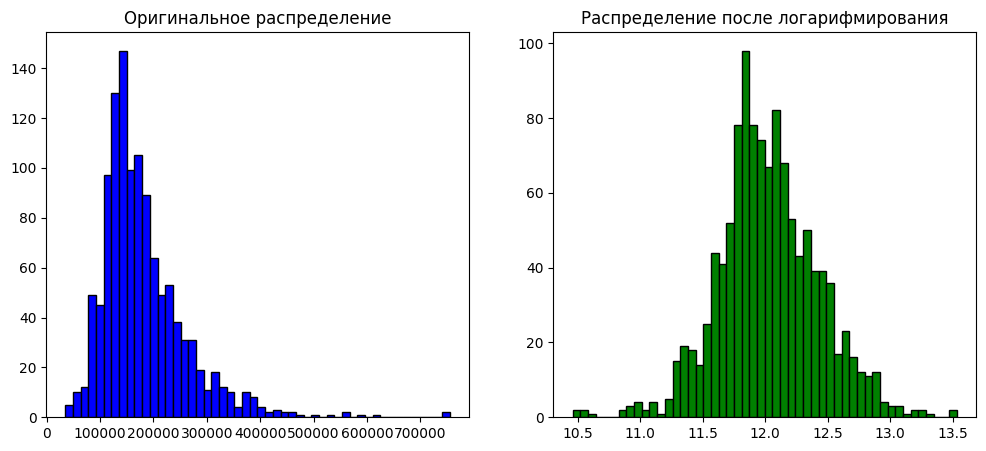

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(train_df["SalePrice"], bins=50, color="blue", edgecolor='black')
plt.title("Оригинальное распределение")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(train_df["SalePrice"]), bins=50, color="green", edgecolor='black')
plt.title("Распределение после логарифмирования")
plt.show()
